<a href="https://colab.research.google.com/github/wherediddavidgo/multitemporal_RSSA/blob/main/ew_distributions_AHG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install netCDF4
import xarray as xr
# from netCDF4 import Dataset
import numpy as np
import pandas as pd
import geopandas as gpd
from google.colab import drive
from matplotlib import pyplot as plt
import datetime
import glob
from tqdm import tqdm
from scipy.stats import lognorm, linregress


In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cb_centerlines = gpd.read_file('/content/drive/MyDrive/river_tinder_assets/centerlines/s2_platte_centerlines_4326.shp').to_crs(3857)

In [4]:
merit_centerlines = gpd.read_file('/content/drive/MyDrive/MERIT/riv_pfaf_7_MERIT_Hydro_v07_Basins_v01_bugfix1.shp').to_crs(3857)

In [5]:
ew_pts1 = gpd.read_file('/content/drive/MyDrive/platte_pts_10000m.shp')[['iindex', 'geometry']]
ew_circles1 = gpd.read_file('/content/drive/MyDrive/river_tinder_assets/all_sites/buffs_3x_width_20250903.shp')[['iindex', 'geometry']]

ew_pts2 = gpd.read_file('/content/drive/MyDrive/river_tinder_assets/gage_sites/gage_points_20250918.shp')[['iindex', 'geometry']]
ew_circles2 = gpd.read_file('/content/drive/MyDrive/river_tinder_assets/gage_sites/gage_circles_3x_20250918.shp')[['iindex', 'geometry']]

ew_pts3 = gpd.read_file('/content/drive/MyDrive/river_tinder_assets/gage_sites/gage_points_extra.shp')[['iindex', 'geometry']]
ew_circles3 = gpd.read_file('/content/drive/MyDrive/river_tinder_assets/gage_sites/gage_circles_3x_extra.shp')[['iindex', 'geometry']]


ew_pts = pd.concat([ew_pts1, ew_pts2, ew_pts3])
ew_pts = gpd.GeoDataFrame(ew_pts, geometry=ew_pts.geometry, crs=4326).to_crs(3857)

ew_circles = pd.concat([ew_circles1, ew_circles2, ew_circles3])
ew_circles = gpd.GeoDataFrame(ew_circles, geometry=ew_circles.geometry).to_crs(3857)
ew_pts = ew_pts.loc[(ew_pts.iindex.isin(ew_circles.iindex)) & (ew_pts.iindex != 30618)]

ew_circles['riv_length'] = ew_circles.apply(lambda x: gpd.sjoin(cb_centerlines, gpd.GeoDataFrame(geometry=[x.geometry], crs=3857)).length.sum(), axis=1)

ew_pts = pd.merge(ew_pts, ew_circles[['iindex', 'riv_length']])
ew_pts = ew_pts.to_crs(3857).sjoin_nearest(merit_centerlines, distance_col='distance_merit')[['iindex', 'geometry', 'riv_length', 'COMID', 'distance_merit', 'order']]

ew_pts = ew_pts.sjoin_nearest(cb_centerlines[['NewSO', 'geometry']], distance_col='distance_cb').drop_duplicates('iindex')

ew_pts

,iindex,geometry,riv_length,COMID,distance_merit,order,index_right,NewSO,distance_cb
0,38577,POINT (-11690505.247 4811857.209),81.082801,74038452,53.288151,4,4997,9,10.629683
1,33809,POINT (-11685635.215 4835085.32),136.538532,74038417,24.918905,4,2998,9,1.070429
2,34632,POINT (-11688434.826 4823704.536),125.759812,74038438,24.136813,4,3995,9,4.604104
3,40608,POINT (-11680394.88 4846335.545),122.568220,74038395,593.019014,4,2002,9,5.646844
4,37091,POINT (-11673614.76 4855615.592),302.318549,74038375,274.707401,4,1000,9,7.395028
...,...,...,...,...,...,...,...,...,...
472,107328,POINT (-10837835.026 5073919.205),937.874503,74029224,9.738052,5,223574,10,2.273456
473,244511,POINT (-11080725.027 4965503.779),1195.506855,74029167,3.425225,6,162885,12,2.794537
474,245153,POINT (-11083844.976 4964870.754),1217.410395,74030651,194.248106,2,368438,12,7.007301
475,246043,POINT (-10718194.959 5055774.457),496.596308,74029691,19.119825,5,130752,10,5.015099


In [6]:
# years = [2018, 2019, 2021, 2022, 2023, 2024]
# months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
df_list = []

files = glob.glob('/content/drive/MyDrive/effwidth_results/all_sites/*20250928.csv')
for f in tqdm(files):
    df_list.append(pd.read_csv(f))

files = glob.glob('/content/drive/MyDrive/effwidth_results/gage_sites/*g*_2025092*.csv')
for f in tqdm(files):
    df_list.append(pd.read_csv(f))

widths = pd.concat(df_list)

widths['date'] = widths.apply(lambda x: datetime.date(int(x['img_id'][10:14]), int(x['img_id'][14:16]), int(x['img_id'][16:18])), axis=1)
widths['date'] = pd.to_datetime(widths.date)

widths = pd.merge(widths, ew_pts, on='iindex', how='left')

widths

100%|██████████| 14/14 [00:03<00:00,  4.25it/s]


,Unnamed: 0,img_id,iindex,n_pixels,n_valid,n_river,n_cloud,n_snow,n_cloudriver,n_edge,n_edgeriver,date,geometry,riv_length,COMID,distance_merit,order,index_right,NewSO,distance_cb
0,0,S2A_13TGF_20240103_0_L2A,9803,308,308,79,0,308,0,58,9,2024-01-03,POINT (-11408584.956 5002072.656),287.446706,74029423.0,38.036051,5.0,39780.0,11.0,5.595291
1,1,S2A_13TGF_20240103_0_L2A,13320,765,765,171,0,743,0,90,16,2024-01-03,POINT (-11398675.129 5005766.481),460.710985,74029423.0,305.704761,5.0,122974.0,11.0,1.232603
2,2,S2A_13TGF_20240103_0_L2A,13696,758,758,154,0,200,0,90,8,2024-01-03,POINT (-11402435.244 5004680.728),448.358320,74029423.0,116.117299,5.0,123267.0,11.0,5.287914
3,3,S2A_13TGF_20240103_0_L2A,7591,1455,1455,260,0,838,0,124,9,2024-01-03,POINT (-11418684.899 5000034.786),621.348928,74029425.0,56.452354,5.0,40556.0,11.0,5.024024
4,4,S2A_13TGF_20240103_0_L2A,36643,1456,1456,281,55,864,0,124,10,2024-01-03,POINT (-11368854.808 5059048.937),646.856009,74029266.0,9.719406,5.0,104367.0,11.0,12.464640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229172,447,S2A_14TPM_20241219_0_L2A,82494,1454,1454,326,0,28,0,124,19,2024-12-19,POINT (-10767564.986 5136958.447),633.810677,74023339.0,22.942618,5.0,251716.0,10.0,4.243144
229173,448,S2A_14TQL_20241020_0_L2A,246043,763,763,196,0,0,0,90,12,2024-10-20,POINT (-10718194.959 5055774.457),496.596308,74029691.0,19.119825,5.0,130752.0,10.0,5.015099
229174,449,S2A_14TPL_20240213_0_L2A,107328,3325,0,0,0,0,0,186,0,2024-02-13,POINT (-10837835.026 5073919.205),937.874503,74029224.0,9.738052,5.0,223574.0,10.0,2.273456
229175,450,S2A_14TNL_20241105_0_L2A,259030,308,0,0,0,0,0,58,0,2024-11-05,POINT (-10991695.037 5017054.391),288.056908,74029356.0,17.759166,4.0,301427.0,10.0,4.650442


In [7]:

ew_pts = gpd.read_file("/content/drive/MyDrive/river_tinder_assets/all_sites/points_20251010.shp")[['iindex', 'geometry']]
ew_circles = gpd.read_file("/content/drive/MyDrive/river_tinder_assets/all_sites/circles_3x_20251010.shp")[['iindex', 'geometry']].to_crs(3857)

# cb_centerlines = gpd.read_file('C:/Users/dego/Documents/local_files/RSSA/Platte_centerlines_masks/vector_centerlines/s2_platte_centerlines.shp')\
#     .set_crs(4326, allow_override=True)\
#     .to_crs(3857)

ew_circles['riv_length'] = ew_circles.apply(lambda x: gpd.sjoin(cb_centerlines, gpd.GeoDataFrame(geometry=[x.geometry], crs=3857)).length.sum(), axis=1)

ew_pts = pd.merge(ew_pts, ew_circles[['iindex', 'riv_length']])
ew_pts = ew_pts.to_crs(3857).sjoin_nearest(merit_centerlines, distance_col='distance_merit')
ew_pts = ew_pts.drop('index_right', axis=1)\
    .sjoin_nearest(cb_centerlines[['NewSO', 'geometry']], distance_col='distance_cb').drop_duplicates('iindex')


In [8]:
df_list = []

files = glob.glob('/content/drive/MyDrive/effwidth_results/20251010/*.csv')
for f in tqdm(files):
    df_list.append(pd.read_csv(f))

widths = pd.concat(df_list)

widths['date'] = widths.apply(lambda x: datetime.date(int(x['img_id'][10:14]), int(x['img_id'][14:16]), int(x['img_id'][16:18])), axis=1)
widths['date'] = pd.to_datetime(widths.date)

widths = gpd.GeoDataFrame(widths, geometry=gpd.points_from_xy(widths.x, widths.y, crs=4326))\
    .to_crs(3857)

widths = gpd.sjoin_nearest(widths, ew_pts.drop('index_right', axis=1))

widths

100%|██████████| 7/7 [00:14<00:00,  2.00s/it]


,img_id,iindex_left,n_pixels,n_valid,n_river,n_cloud,n_snow,n_cloudriver,n_edge,n_edgeriver,...,slope_taud,NextDownID,maxup,up1,up2,up3,up4,distance_merit,NewSO,distance_cb
0,S2A_14TNM_20181107_0_L2A,48196,42,42,9,0,0,0,23,1,...,0.001272,74023856,2,74023984,74026465,0,0,71.057939,7,9.559782
1,S2A_14TNM_20181107_0_L2A,105223,41,41,7,0,0,0,22,1,...,0.001264,74023984,2,74024579,74024717,0,0,72.541614,7,9.412801
2,S2A_14TNM_20181107_0_L2A,61517,40,40,2,7,0,0,22,0,...,0.000794,74023797,2,74023856,74026027,0,0,136.107371,7,2.003440
3,S2A_14TNM_20181107_0_L2A,19705,41,41,17,0,0,0,23,4,...,0.001483,74023835,2,74024211,74027238,0,0,39.900221,8,3.397580
4,S2A_14TNM_20181107_0_L2A,57705,38,38,10,2,0,1,22,3,...,0.001272,74023856,2,74023984,74026465,0,0,95.611298,7,5.794611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134880,S2A_13TGG_20240711_0_L2A,117366,-999,-999,-999,-999,-999,-999,-999,-999,...,0.001003,74029281,2,74029289,74030721,0,0,239.170209,11,3.935579
134881,S2A_13TGG_20240711_0_L2A,108544,-999,-999,-999,-999,-999,-999,-999,-999,...,0.000988,74029274,2,74029281,74036671,0,0,316.602787,11,1.363074
134882,S2A_13TGG_20240711_0_L2A,108793,-999,-999,-999,-999,-999,-999,-999,-999,...,0.000988,74029274,2,74029281,74036671,0,0,70.325544,11,1.777842
134883,S2A_13TGG_20240711_0_L2A,117554,-999,-999,-999,-999,-999,-999,-999,-999,...,0.001003,74029281,2,74029289,74030721,0,0,57.355992,11,9.167285


In [9]:
widths['sat_width_m'] = widths.n_river * 100 / widths.riv_length
widths['fraction_cloud'] = widths.n_cloud / widths.n_pixels
widths['fraction_snow'] = widths.n_snow / widths.n_pixels
widths['fraction_edgeriver'] = widths.n_edgeriver / widths.n_edge

widths_filtered = widths.copy()
widths_filtered = widths_filtered.loc[widths_filtered.fraction_cloud < 0.2]
widths_filtered = widths_filtered.loc[widths_filtered.fraction_snow < 0.2]
widths_filtered = widths_filtered.loc[((widths_filtered.n_cloud - widths_filtered.n_cloudriver) / widths_filtered.n_valid) < 0.2]
widths_filtered = widths_filtered.loc[widths_filtered.fraction_edgeriver < 0.4]
widths_filtered = widths_filtered.loc[widths_filtered.n_edgeriver < widths_filtered.n_river]
widths_filtered.COMID = np.uint32(widths_filtered.COMID)

In [10]:
Q2024 = xr.open_dataset('/content/drive/MyDrive/grades_Q/GRADES-hydroDL_V2.0_pfaf_07_2024.nc')
Q2023 = xr.open_dataset('/content/drive/MyDrive/grades_Q/GRADES-hydroDL_V2.0_pfaf_07_2023.nc')
Q2022 = xr.open_dataset('/content/drive/MyDrive/grades_Q/GRADES-hydroDL_V2.0_pfaf_07_2022.nc')
Q2021 = xr.open_dataset('/content/drive/MyDrive/grades_Q/GRADES-hydroDL_V2.0_pfaf_07_2021.nc')
Q2020 = xr.open_dataset('/content/drive/MyDrive/grades_Q/GRADES-hydroDL_V2.0_pfaf_07_2020.nc')
Q2019 = xr.open_dataset('/content/drive/MyDrive/grades_Q/GRADES-hydroDL_V2.0_pfaf_07_2019.nc')
Q2018 = xr.open_dataset('/content/drive/MyDrive/grades_Q/GRADES-hydroDL_V2.0_pfaf_07_2018.nc')

In [11]:
COMID_arr = widths_filtered.COMID.unique()

Q2024 = Q2024.sel(rivid=COMID_arr)
Q2023 = Q2023.sel(rivid=COMID_arr)
Q2022 = Q2022.sel(rivid=COMID_arr)
Q2021 = Q2021.sel(rivid=COMID_arr)
Q2020 = Q2020.sel(rivid=COMID_arr)
Q2019 = Q2019.sel(rivid=COMID_arr)
Q2018 = Q2018.sel(rivid=COMID_arr)

all_Q = xr.concat([Q2018, Q2019, Q2020, Q2021, Q2022, Q2023, Q2024], dim='time')

/tmp/ipython-input-2254169007.py:11: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  all_Q = xr.concat([Q2018, Q2019, Q2020, Q2021, Q2022, Q2023, Q2024], dim='time')


In [13]:
Qdf = all_Q.to_dataframe()\
    .reset_index()\
    .drop('nerr', axis=1)\
    .drop_duplicates(['time', 'rivid'])\
    .rename(columns={'time': 'date', 'rivid': 'COMID'})

Qdf.COMID = np.uint32(Qdf.COMID)

Qdf = Qdf.set_index(['date', 'COMID'])

Qdf['Q_percentile'] = Qdf.groupby('COMID')['Qout'].rank(pct=True)

decile_bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
quintile_bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
quartile_bins = [0, 0.25, 0.5, 0.75, 1.0]

Qdf['decile'] = Qdf.groupby('COMID')['Q_percentile'].transform(
    lambda x: pd.cut(x, bins=decile_bins, labels=False)
)
Qdf['quintile'] = Qdf.groupby('COMID')['Q_percentile'].transform(
    lambda x: pd.cut(x, bins=quintile_bins, labels=False)
)
Qdf['quartile'] = Qdf.groupby('COMID')['Q_percentile'].transform(
    lambda x: pd.cut(x, bins=quartile_bins, labels=False)
)


Qdf

Qout      Qout_err           crs           lon  \
date       COMID                                                            
2018-01-01 74023944    0.003375           NaN           NaN  9.969210e+36   
           74024231    0.002171           NaN           NaN  9.969210e+36   
           74023808    0.015069           NaN           NaN  9.969210e+36   
           74024019    0.001689           NaN           NaN  9.969210e+36   
           74023676    0.049701           NaN           NaN  9.969210e+36   
...                         ...           ...           ...           ...   
2024-12-31 74029276    0.101944  9.969210e+36 -2.147484e+09  9.969210e+36   
           74029287    0.022546  9.969210e+36 -2.147484e+09  9.969210e+36   
           74029355    0.081350  9.969210e+36 -2.147484e+09  9.969210e+36   
           74029454  100.371552  9.969210e+36 -2.147484e+09  9.969210e+36   
           74023342    1.149084  9.969210e+36 -2.147484e+09  9.969210e+36   

                              lat  Q_percentile  decile  quintile  quartile  
date       COMID                                                             
2018-01-01 74023944  9.969210e+36      0.267892       2         1         1  
           74024231  9.969210e+36      0.146265       1         0         0  
           74023808  9.969210e+36      0.152522       1         0         0  
           74024019  9.969210e+36      0.176379       1         0         0  
           74023676  9.969210e+36      0.115761       1         0         0  
...                           ...           ...     ...       ...       ...  
2024-12-31 74029276  9.969210e+36      0.214314       2         1         0  
           74029287  9.969210e+36      0.349628       3         1         1  
           74029355  9.969210e+36      0.386781       3         1         1  
           74029454  9.969210e+36      0.837309       8         4         3  
           74023342  9.969210e+36      0.341416       3         1         1  

[1311741 rows x 9 columns]

In [ ]:
widths_filtered.NewSO.unique()

array([ 7,  8,  6,  9, 11, 10, 12])

In [14]:
Qw = widths_filtered.set_index(['date', 'COMID'])\
    .join(Qdf)

Qw_reach = Qw.groupby(['COMID', 'date']).agg(
    mean_width = ('sat_width_m', lambda x: x.mean()),
    median_width = ('sat_width_m', lambda x: x.median()),
    min_width = ('sat_width_m', lambda x: x.min()),
    max_width = ('sat_width_m', lambda x: x.max()),
    n_meas = ('sat_width_m', lambda x: x.count()),
    Q_cms = ('Qout', lambda x: x.mean())
).reset_index()

Qw
#  ['Q_percentile'] = Qw_reach.groupby('COMID')['']

img_id  iindex_left  n_pixels  n_valid  \
date       COMID                                                                
2018-11-07 74023944  S2A_14TNM_20181107_0_L2A        48196        42       42   
           74024231  S2A_14TNM_20181107_0_L2A       105223        41       41   
           74023808  S2A_14TNM_20181107_0_L2A        61517        40       40   
           74024019  S2A_14TNM_20181107_0_L2A        19705        41       41   
           74023944  S2A_14TNM_20181107_0_L2A        57705        38       38   
...                                       ...          ...       ...      ...   
2024-01-21 74022662  S2B_13TDH_20240121_0_L2A        64535      1221     1221   
           74022663  S2B_13TDH_20240121_0_L2A        57202      1451     1451   
           74022661  S2B_13TDH_20240121_0_L2A        65158      1709     1709   
           74022662  S2B_13TDH_20240121_0_L2A        64988      2588     2588   
           74022663  S2B_13TDH_20240121_0_L2A        57394      3768     3768   

                     n_river  n_cloud  n_snow  n_cloudriver  n_edge  \
date       COMID                                                      
2018-11-07 74023944        9        0       0             0      23   
           74024231        7        0       0             0      22   
           74023808        2        7       0             0      22   
           74024019       17        0       0             0      23   
           74023944       10        2       0             1      22   
...                      ...      ...     ...           ...     ...   
2024-01-21 74022662      138        0       0             0     114   
           74022663       15       40       0             0     124   
           74022661      139        0       0             0     135   
           74022662       80        0       0             0     166   
           74022663      612        0       0             0     198   

                     n_edgeriver  ...  fraction_edgeriver      Qout  \
date       COMID                  ...                                 
2018-11-07 74023944            1  ...            0.043478  0.003083   
           74024231            1  ...            0.045455  0.006097   
           74023808            0  ...            0.000000  1.005342   
           74024019            4  ...            0.173913  0.022262   
           74023944            3  ...            0.136364  0.003083   
...                          ...  ...                 ...       ...   
2024-01-21 74022662            8  ...            0.070175  1.866121   
           74022663            0  ...            0.000000  0.297479   
           74022661            5  ...            0.037037  0.573394   
           74022662            0  ...            0.000000  1.866121   
           74022663           14  ...            0.070707  0.297479   

                         Qout_err           crs           lon           lat  \
date       COMID                                                              
2018-11-07 74023944           NaN           NaN  9.969210e+36  9.969210e+36   
           74024231           NaN           NaN  9.969210e+36  9.969210e+36   
           74023808           NaN           NaN  9.969210e+36  9.969210e+36   
           74024019           NaN           NaN  9.969210e+36  9.969210e+36   
           74023944           NaN           NaN  9.969210e+36  9.969210e+36   
...                           ...           ...           ...           ...   
2024-01-21 74022662  9.969210e+36 -2.147484e+09  9.969210e+36  9.969210e+36   
           74022663  9.969210e+36 -2.147484e+09  9.969210e+36  9.969210e+36   
           74022661  9.969210e+36 -2.147484e+09  9.969210e+36  9.969210e+36   
           74022662  9.969210e+36 -2.147484e+09  9.969210e+36  9.969210e+36   
           74022663  9.969210e+36 -2.147484e+09  9.969210e+36  9.969210e+36   

                     Q_percentile  decile  quintile  quartile  
date       COMID                             

In [ ]:
Qw_reach

In [ ]:
Qw.columns

In [15]:
Qw_reach = pd.merge(Qw_reach, ew_pts[['COMID', 'NewSO']], on='COMID', how='left').set_index(['COMID', 'date'])

In [16]:
orders = Qw.sort_values('NewSO')['NewSO'].unique()
orders

array([ 6,  7,  8,  9, 10, 11, 12])

In [ ]:
(decile_bins)

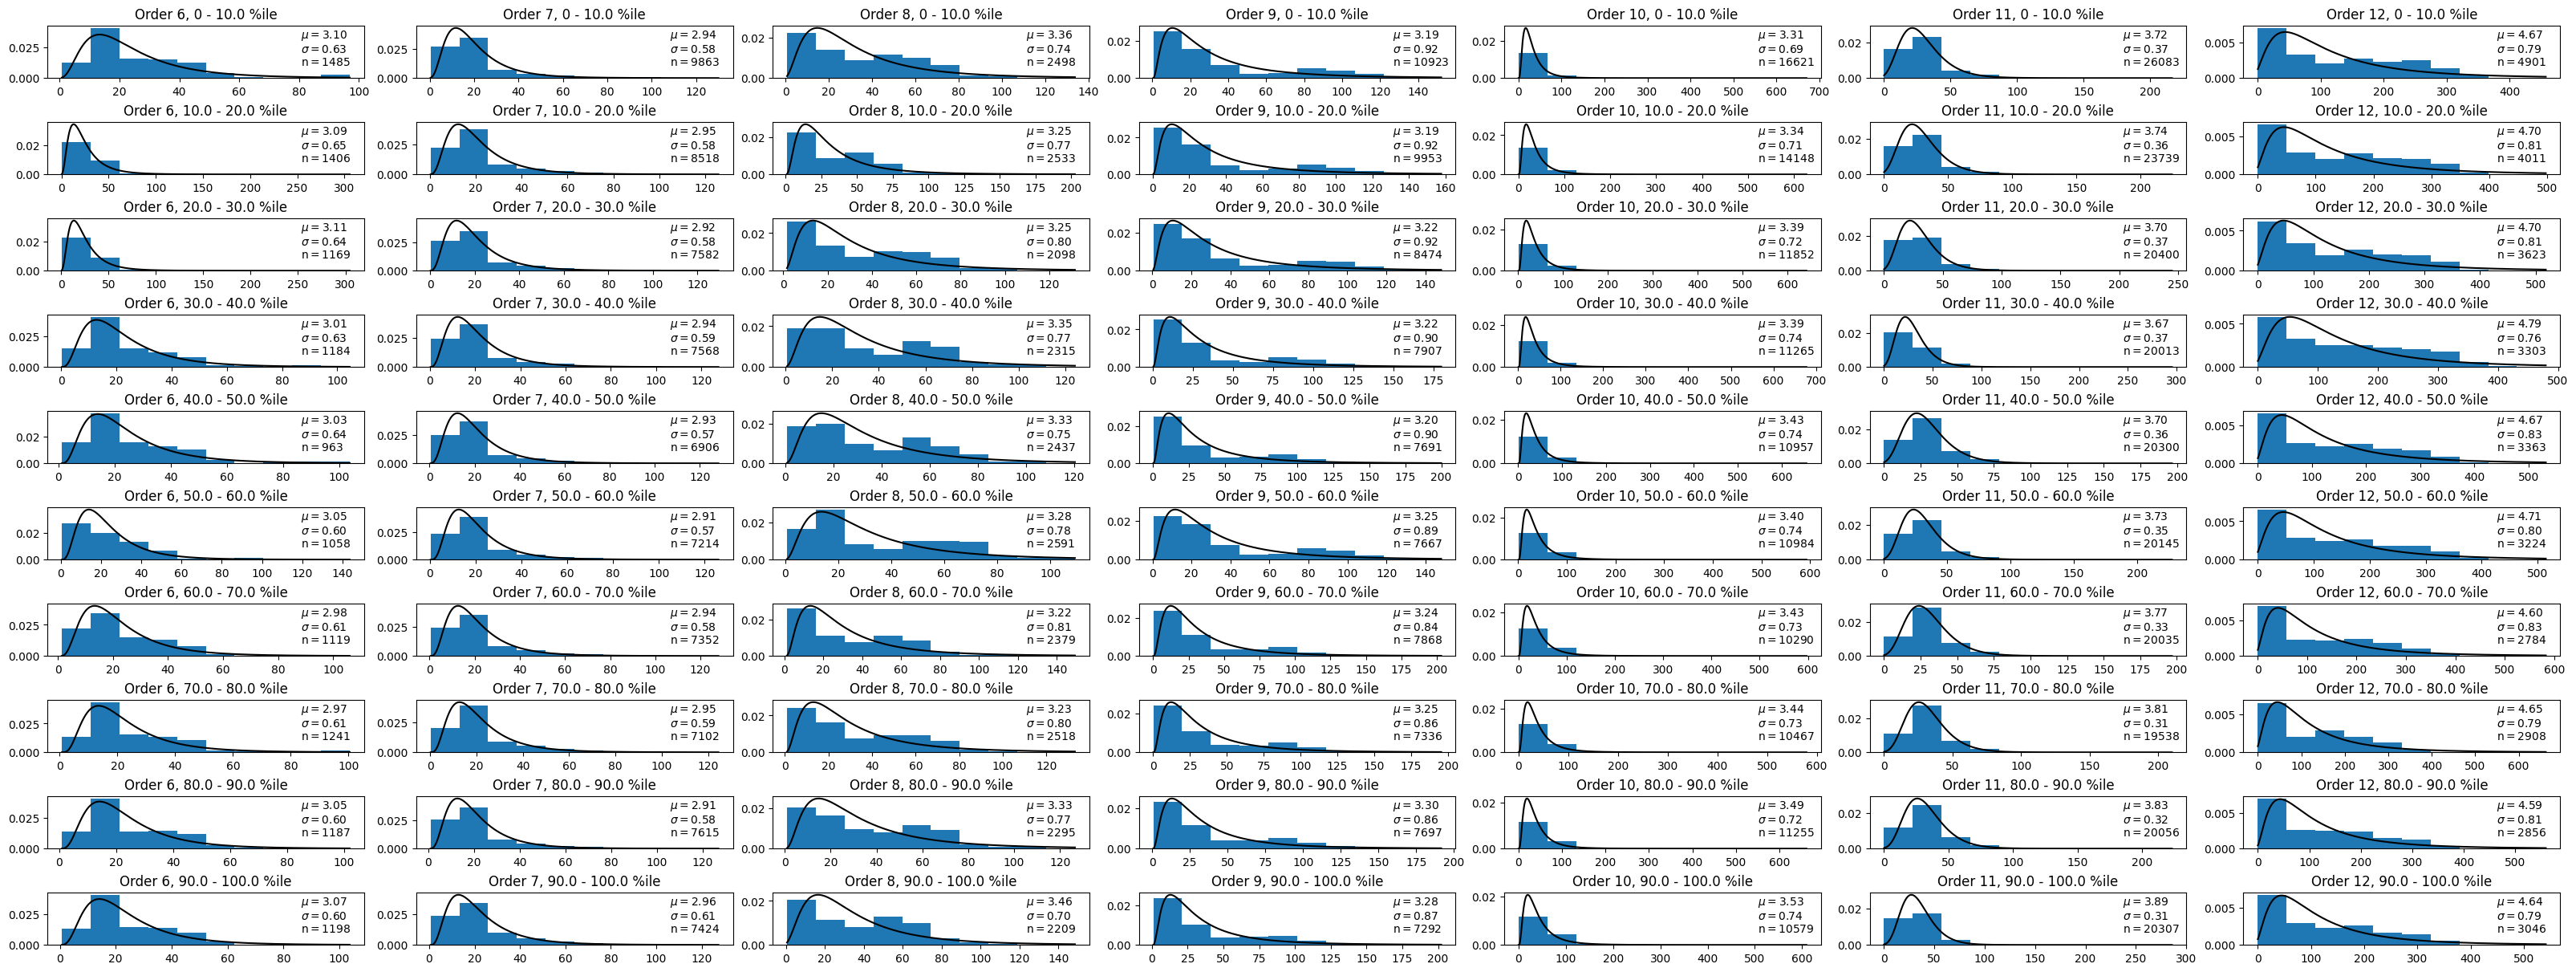

In [17]:
sigmas = []
mus = []
os = []
qs = []

fig, axs = plt.subplots(10, 7, figsize=(32, 12), constrained_layout=True)

for q in range(len(decile_bins) - 1):
    for o in range(len(orders)):
        order = orders[o]
        ax = axs[q, o]
        df = Qw.loc[(Qw.NewSO == order) & (Qw.decile == q)]

        x = np.linspace(min(df.sat_width_m), max(df.sat_width_m), 1000)

        shape, loc, scale = lognorm.fit(df.sat_width_m)
        sigma = shape
        mu = np.log(scale)
        pdf_fitted = lognorm.pdf(x, shape, scale=scale, loc=loc)

        sigmas.append(sigma)
        mus.append(mu)
        os.append(order)
        qs.append(q)


        ax.hist(df.sat_width_m, density=True)
        ax.plot(x, pdf_fitted, color='black')

        param_label = '\n'.join((
            r'$\mu=%.2f$' % (mu, ),
            r'$\sigma=%.2f$' % (sigma, ),
            r'$\mathrm{n}=%.0f$' % (len(df) )))
        ax.text(0.8, 0.95, param_label, transform=ax.transAxes, verticalalignment='top')
        ax.set_title(f'Order {order}, {100 * decile_bins[q]} - {100 * decile_bins[q + 1]} %ile')
        # bins smaller

        # try same x axis and count y axis

Text(0.02, 0.5, 'Flow percentile')

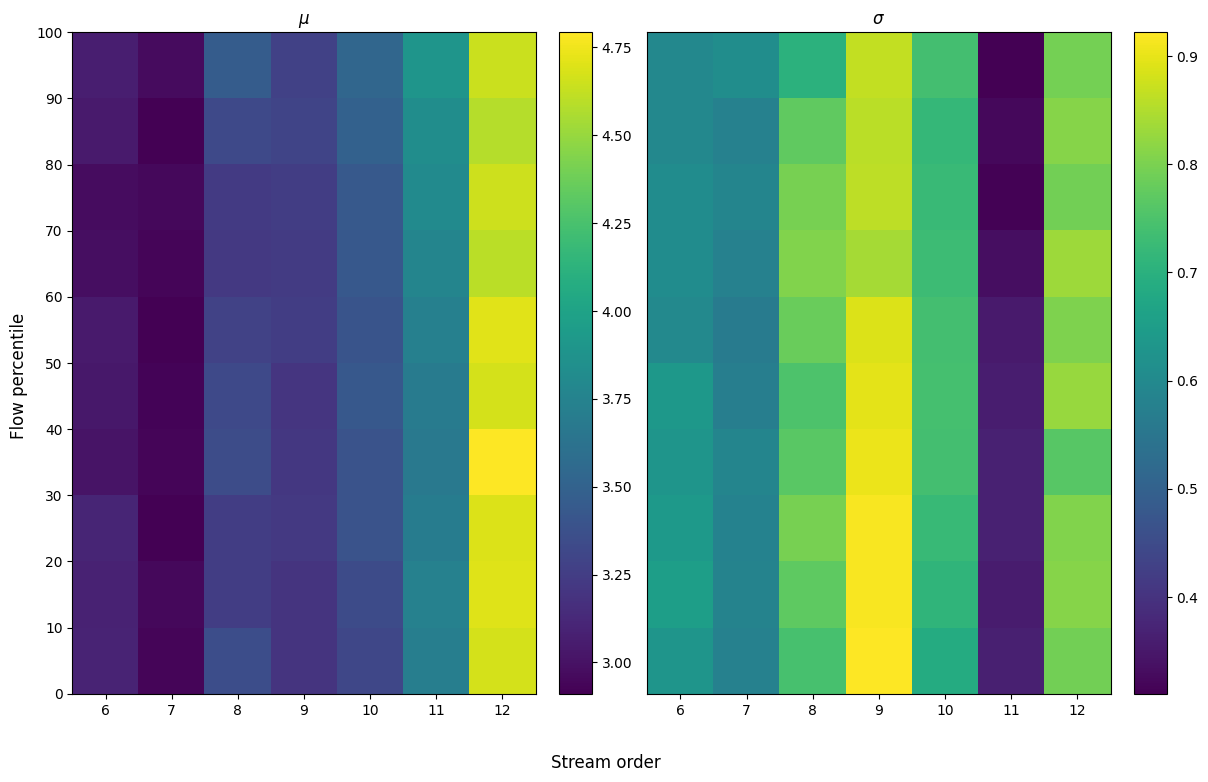

In [18]:
osarray = np.array(os.copy())

osarray.shape = (10, 7)

os_axis = osarray[1]
os_axis = [int(os_axis[o]) for o in range(len(os_axis))]
qsarray = np.array(qs.copy())
qsarray.shape = (10, 7)
qs_axis = qsarray[:, 1]
qs_axis = [int(decile_bins[d] * 100) for d in range(len(decile_bins))]


musarray = np.array(mus.copy())
musarray.shape = (10, 7)

sigmasarray = np.array(sigmas.copy())
sigmasarray.shape = (10, 7)

fig, (mu_img, sigma_img) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 8))
mshow = mu_img.imshow(np.flip(musarray, axis=0))
mu_img.set_xticks([0, 1, 2, 3, 4, 5, 6])
mu_img.set_xticklabels(os_axis)

mu_img.set_yticks([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5])
mu_img.set_yticklabels(np.flip(qs_axis))
mu_img.set_title(r'$\mu$')

im_ratio = musarray.shape[0]/musarray.shape[1]

plt.colorbar(mshow, orientation="vertical", fraction=0.05*im_ratio, ax=mu_img, pad=0.05)


sshow = sigma_img.imshow(np.flip(sigmasarray, axis=0))
sigma_img.set_xticks([0, 1, 2, 3, 4, 5, 6])
sigma_img.set_xticklabels(os_axis)

# fig.set_constrained_layout_pads(w_pad=1./72, h_pad=1./72, wspace=0.01, hspace=0.01)

# sigma_img.set_yticks([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5])
sigma_img.yaxis.set_visible(False)
sigma_img.set_title(r'$\sigma$')

plt.colorbar(sshow, orientation="vertical", fraction=0.05*im_ratio, ax=sigma_img, pad=0.05)

fig.supxlabel('Stream order')
fig.supylabel('Flow percentile')

In [ ]:
decile_bins

[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

-0.007874622998417036
0.0005034759369642955
0.005615307329338363
0.010750180261790431
0.020562915021322126
0.018691014224721785
-0.011199795706272648


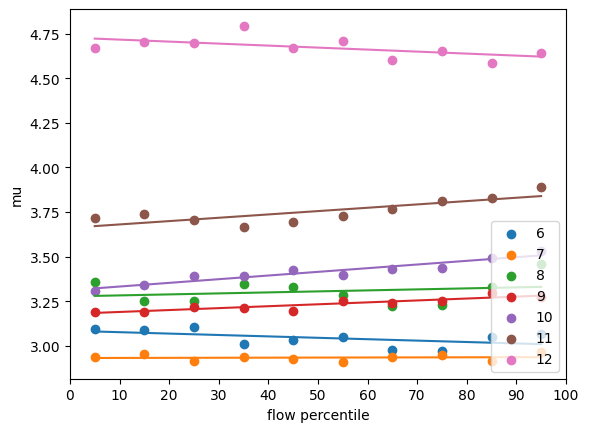

In [32]:
fig, ax = plt.subplots()
for o in orders:
    percline = musarray[:, o - 6]

    ax.scatter(range(0, 10), percline, label=o)
    s, i, r, _, _ = linregress(range(0, 10), percline)
    ax.plot(range(0, 10), range(0, 10) * s + i)
    ax.set_ylabel('mu')
    ax.set_xlabel('flow percentile')
    ax.set_xticks([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5])
    ax.set_xticklabels([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    ax.legend(loc='lower right')
    print(s)

In [ ]:
Qw_decilemeans = Qw.copy()
Qw_decilemeans = Qw_decilemeans.groupby(['decile', 'geometry'])['sat_width_m'].mean()
Qw_decilemeans = pd.merge(Qw_decilemeans.reset_index(), Qw[['geometry', 'NewSO']], on='geometry', how='left')

In [ ]:
Qw

img_id  iindex_left  n_pixels  n_valid  \
date       COMID                                                                
2018-11-07 74023944  S2A_14TNM_20181107_0_L2A        48196        42       42   
           74024231  S2A_14TNM_20181107_0_L2A       105223        41       41   
           74023808  S2A_14TNM_20181107_0_L2A        61517        40       40   
           74024019  S2A_14TNM_20181107_0_L2A        19705        41       41   
           74023944  S2A_14TNM_20181107_0_L2A        57705        38       38   
...                                       ...          ...       ...      ...   
2024-01-21 74022662  S2B_13TDH_20240121_0_L2A        64535      1221     1221   
           74022663  S2B_13TDH_20240121_0_L2A        57202      1451     1451   
           74022661  S2B_13TDH_20240121_0_L2A        65158      1709     1709   
           74022662  S2B_13TDH_20240121_0_L2A        64988      2588     2588   
           74022663  S2B_13TDH_20240121_0_L2A        57394      3768     3768   

                     n_river  n_cloud  n_snow  n_cloudriver  n_edge  \
date       COMID                                                      
2018-11-07 74023944        9        0       0             0      23   
           74024231        7        0       0             0      22   
           74023808        2        7       0             0      22   
           74024019       17        0       0             0      23   
           74023944       10        2       0             1      22   
...                      ...      ...     ...           ...     ...   
2024-01-21 74022662      138        0       0             0     114   
           74022663       15       40       0             0     124   
           74022661      139        0       0             0     135   
           74022662       80        0       0             0     166   
           74022663      612        0       0             0     198   

                     n_edgeriver  ...  fraction_edgeriver      Qout  \
date       COMID                  ...                                 
2018-11-07 74023944            1  ...            0.043478  0.003083   
           74024231            1  ...            0.045455  0.006097   
           74023808            0  ...            0.000000  1.005342   
           74024019            4  ...            0.173913  0.022262   
           74023944            3  ...            0.136364  0.003083   
...                          ...  ...                 ...       ...   
2024-01-21 74022662            8  ...            0.070175  1.866121   
           74022663            0  ...            0.000000  0.297479   
           74022661            5  ...            0.037037  0.573394   
           74022662            0  ...            0.000000  1.866121   
           74022663           14  ...            0.070707  0.297479   

                         Qout_err           crs           lon           lat  \
date       COMID                                                              
2018-11-07 74023944           NaN           NaN  9.969210e+36  9.969210e+36   
           74024231           NaN           NaN  9.969210e+36  9.969210e+36   
           74023808           NaN           NaN  9.969210e+36  9.969210e+36   
           74024019           NaN           NaN  9.969210e+36  9.969210e+36   
           74023944           NaN           NaN  9.969210e+36  9.969210e+36   
...                           ...           ...           ...           ...   
2024-01-21 74022662  9.969210e+36 -2.147484e+09  9.969210e+36  9.969210e+36   
           74022663  9.969210e+36 -2.147484e+09  9.969210e+36  9.969210e+36   
           74022661  9.969210e+36 -2.147484e+09  9.969210e+36  9.969210e+36   
           74022662  9.969210e+36 -2.147484e+09  9.969210e+36  9.969210e+36   
           74022663  9.969210e+36 -2.147484e+09  9.969210e+36  9.969210e+36   

                     Q_percentile  decile  quintile  quartile  
date       COMID                             

In [ ]:
import matplotlib.colors as mcolors
cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=0, vmax=9)
mapper = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
Qw['decile_color'] = Qw.decile.apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
Qw

Unnamed: 0                    img_id  iindex  n_pixels  \
date       COMID                                                              
2024-01-03 74029238          12  S2A_13TGF_20240103_0_L2A  158552       293   
           74022645          32  S2A_13TEG_20240103_0_L2A   99883       310   
           74022532          37  S2A_13TEG_20240103_0_L2A   86992       759   
           74022647          39  S2A_13TEG_20240103_0_L2A   78407       944   
           74022533          40  S2A_13TEG_20240103_0_L2A   85825      1077   
...                         ...                       ...     ...       ...   
2024-03-10 74029167         444  S2A_14TML_20240310_0_L2A  244511      5647   
           74030651         445  S2A_14TML_20240310_0_L2A  245153      5570   
2024-12-19 74023339         447  S2A_14TPM_20241219_0_L2A   82494      1454   
2024-10-20 74029691         448  S2A_14TQL_20241020_0_L2A  246043       763   
2024-02-18 74029691         451  S2B_15TTF_20240218_0_L2A  246043       760   

                     n_valid  n_river  n_cloud  n_snow  n_cloudriver  n_edge  \
date       COMID                                                               
2024-01-03 74029238      293       76        0       0             0      57   
           74022645      310       61        0       0             0      59   
           74022532      759       94        0       0             0      91   
           74022647      944      138        0       0             0     100   
           74022533     1077      129        0       0             0     108   
...                      ...      ...      ...     ...           ...     ...   
2024-03-10 74029167     5647     1326        0       0             0     243   
           74030651     5570      767        0       0             0     240   
2024-12-19 74023339     1454      326        0      28             0     124   
2024-10-20 74029691      763      196        0       0             0      90   
2024-02-18 74029691      760      214        0       0             0      90   

                     ...       Qout      Qout_err           crs           lon  \
date       COMID     ...                                                        
2024-01-03 74029238  ...   1.821875  9.969210e+36 -2.147484e+09  9.969210e+36   
           74022645  ...   0.078781  9.969210e+36 -2.147484e+09  9.969210e+36   
           74022532  ...  12.746226  9.969210e+36 -2.147484e+09  9.969210e+36   
           74022647  ...   2.276201  9.969210e+36 -2.147484e+09  9.969210e+36   
           74022533  ...  38.177040  9.969210e+36 -2.147484e+09  9.969210e+36   
...                  ...        ...           ...           ...           ...   
2024-03-10 74029167  ...   0.897539  9.969210e+36 -2.147484e+09  9.969210e+36   
           74030651  ...   0.006511  9.969210e+36 -2.147484e+09  9.969210e+36   
2024-12-19 74023339  ...   0.069348  9.969210e+36 -2.147484e+09  9.969210e+36   
2024-10-20 74029691  ...   0.514775  9.969210e+36 -2.147484e+09  9.969210e+36   
2024-02-18 74029691  ...   1.034266  9.969210e+36 -2.147484e+09  9.969210e+36   

                              lat  Q_percentile  decile  quintile  quartile  \
date       COMID                                                              
2024-01-03 74029238  9.969210e+36      0.362925       3         1         1   
           74022645  9.969210e+36      0.439969       4         2         1   
           74022532  9.969210e+36      0.533438       5         2         2   
           74022647  9.969210e+36      0.437231       4         2         1   
           74022533  9.969210e+36      0.513101       5         2         2   
...                           ...           ...     ...       ...       ...   
2024-03-10 74029167  9.969210e+36      0.425890       4         2         1   
           74030651  9.969210e+36      0.679312       6         3         2   
2024-12-19 74023339  9.969210e+36      0.245209       2         1         0   
2024-10-20 74029691  9.969210

In [ ]:
Qw

img_id  iindex_left  n_pixels  n_valid  \
date       COMID                                                                
2018-11-07 74027427  S2A_14TNM_20181107_0_L2A         9172       524      524   
           74023379  S2A_14TNM_20181107_0_L2A        85222      1707     1707   
           74023501  S2A_14TNM_20181107_0_L2A        11535       519      519   
           74030098  S2A_14TNM_20181107_0_L2A        87905      4168     4168   
           74030098  S2A_14TNM_20181107_0_L2A        88203      4166     4166   
...                                       ...          ...       ...      ...   
2024-01-21 74022673  S2B_13TDH_20240121_0_L2A        63487      1188     1188   
           74022685  S2B_13TDH_20240121_0_L2A       122797      1221     1221   
           74022662  S2B_13TDH_20240121_0_L2A        64535      1221     1221   
           74022661  S2B_13TDH_20240121_0_L2A        65158      1709     1709   
           74022663  S2B_13TDH_20240121_0_L2A        57394      3768     3768   

                     n_river  n_cloud  n_snow  n_cloudriver  n_edge  \
date       COMID                                                      
2018-11-07 74027427       77       36       0            18      76   
           74023379      452       90       0            45     134   
           74023501      106       97       0            35      76   
           74030098      850       44       0            20     209   
           74030098      713      124       0            65     210   
...                      ...      ...     ...           ...     ...   
2024-01-21 74022673      179        0       0             0     112   
           74022685      285        0      12             0     115   
           74022662      138        0       0             0     114   
           74022661      139        0       0             0     135   
           74022663      612        0       0             0     198   

                     n_edgeriver  ...  fraction_edgeriver       Qout  \
date       COMID                  ...                                  
2018-11-07 74027427            6  ...            0.078947   0.058349   
           74023379           19  ...            0.141791   0.038893   
           74023501           13  ...            0.171053   0.071112   
           74030098           23  ...            0.110048  11.829874   
           74030098           19  ...            0.090476  11.829874   
...                          ...  ...                 ...        ...   
2024-01-21 74022673            7  ...            0.062500   2.752837   
           74022685           14  ...            0.121739   0.246386   
           74022662            8  ...            0.070175   1.866121   
           74022661            5  ...            0.037037   0.573394   
           74022663           14  ...            0.070707   0.297479   

                         Qout_err           crs           lon           lat  \
date       COMID                                                              
2018-11-07 74027427           NaN           NaN  9.969210e+36  9.969210e+36   
           74023379           NaN           NaN  9.969210e+36  9.969210e+36   
           74023501           NaN           NaN  9.969210e+36  9.969210e+36   
           74030098           NaN           NaN  9.969210e+36  9.969210e+36   
           74030098           NaN           NaN  9.969210e+36  9.969210e+36   
...                           ...           ...           ...           ...   
2024-01-21 74022673  9.969210e+36 -2.147484e+09  9.969210e+36  9.969210e+36   
           74022685  9.969210e+36 -2.147484e+09  9.969210e+36  9.969210e+36   
           74022662  9.969210e+36 -2.147484e+09  9.969210e+36  9.969210e+36   
           74022661  9.969210e+36 -2.147484e+09  9.969210e+36  9.969210e+36   
           74022663  9.969210e+36 -2.147484e+09  9.969210e+36  9.969210e+36   

                     Q_percentile  decile  quintile  quartile  
date       COMID                

In [ ]:
Qw_mean = Qw.copy()
Qw_mean = Qw_mean.groupby('geometry').agg(mean_width = ('sat_width_m', lambda x: x.mean()), NewSO = ('NewSO', lambda x: x.mean()))
Qw_mean

,mean_width,NewSO
geometry,,
POINT (-11669824.861 4892746.135),14.344023,9.0
POINT (-11670794.797 4890560.649),13.919003,9.0
POINT (-11670115.246 4888558.794),11.355858,9.0
POINT (-11673295.088 4901991.719),21.500183,9.0
POINT (-11670145.029 4895076.379),24.095939,9.0
...,...,...
POINT (-11020535.1 4964198.646),41.484793,7.0
POINT (-11021495.108 4963644.319),43.690038,6.0
POINT (-11021474.756 4962273.361),106.367996,12.0


In [ ]:
pal = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'gray']

6: 2.6454810328323686, 0.7843327416482111
7: 2.5578055137974904, 0.8129955526271604
8: 2.7539471706892114, 1.153523882909248
9: 3.3206676471742416, 0.8206267157593662
10: 3.111950821501335, 0.9725946085686774
11: 3.5191695439661905, 0.3587323749456945
12: 4.655274629985911, 0.6992630660380205


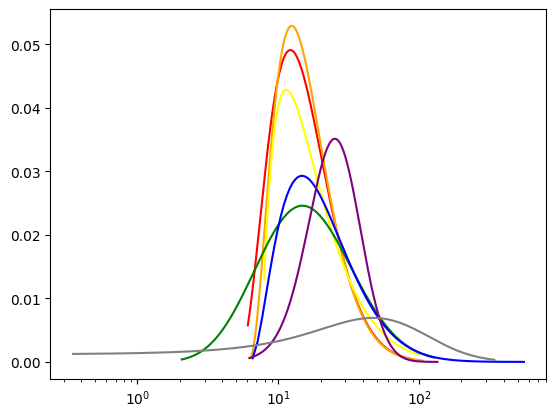

In [ ]:
meansig = []
meanmu = []


# fig, axs = plt.subplots(1, 7, constrained_layout=True, figsize=(18, 6))
fig, ax = plt.subplots()
for o in range(len(orders)):
    # ax = axs.flatten()[o]
    order = orders[o]

    df = Qw_mean.loc[(Qw_mean.NewSO == order)]

    x = np.linspace(min(df.mean_width), max(df.mean_width), 1000)

    shape, loc, scale = lognorm.fit(df.mean_width)
    sigma = shape
    mu = np.log(scale)
    pdf_fitted = lognorm.pdf(x, shape, scale=scale, loc=loc)

    # ax.hist(df.mean_width)
    ax.plot(x, pdf_fitted, color=pal[o])
    ax.set_xscale('log')
    ax.set_xscale('log')

    meansig.append(sigma)
    meanmu.append(mu)
    # os.append(order)

    print(f'{order}: {mu}, {sigma}')

In [ ]:
carterstats = pd.DataFrame({
    'order': range(1, 14),
    'sigma': [0.784,
        0.736,
        0.740,
        0.759,
        0.512,
        0.715,
        0.426,
        0.337,
        0.982,
        0.595,
        0.741,
        0.563,
        0.494],
    'mu': [-0.961,
        -0.415,
        0.202,
        1.085,
        1.628,
        1.830,
        2.386,
        3.046,
        3.748,
        3.905,
        5.335,
        6.003,
        6.744]})
carterstats = carterstats.loc[(carterstats.order >= 6) & (carterstats.order <= 12)]

Text(0.5, 1.0, 'sigma')

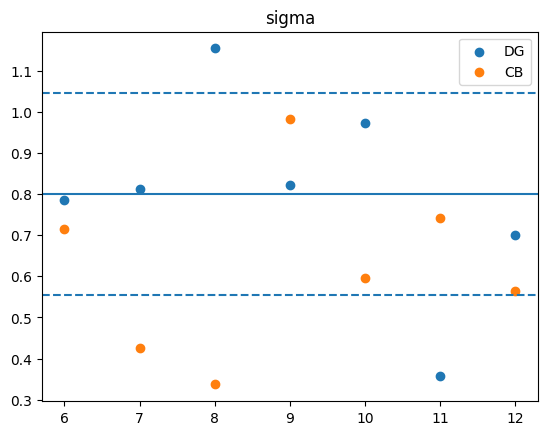

In [ ]:
statdf = pd.DataFrame({
    'order': orders,
    'sigma': meansig,
    'mu': meanmu})

fig, ax = plt.subplots()
ax.scatter(statdf.order, statdf.sigma, label='DG')
ax.scatter(carterstats.order, carterstats.sigma, label='CB')
ax.axhline(statdf.sigma.mean())
ax.axhline(statdf.sigma.mean() - statdf.sigma.std(),  linestyle= '--')
ax.axhline(statdf.sigma.mean() + statdf.sigma.std(),  linestyle= '--')

# ax.axhline(carterstats.sigma.mean())
# ax.axhline(carterstats.sigma.mean() - carterstats.sigma.std(),  linestyle= '--', c='tab:orange')
# ax.axhline(carterstats.sigma.mean() + carterstats.sigma.std(),  linestyle= '--', c='tab:orange')


ax.legend()
ax.set_title('sigma')

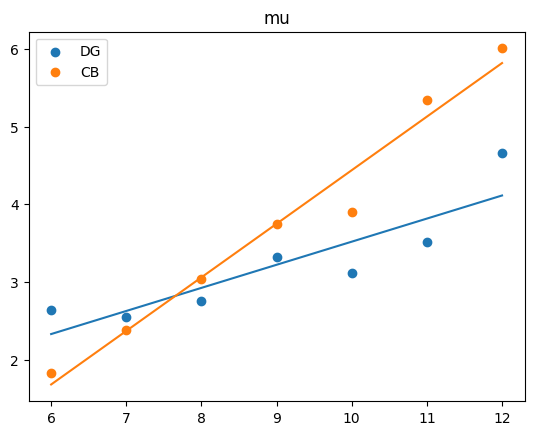

In [ ]:
fig, ax = plt.subplots()
ax.scatter(statdf.order, statdf.mu, label='DG')
ax.scatter(carterstats.order, carterstats.mu, label='CB')
ax.legend()
ax.set_title('mu')

dgslope, dgint, dgr, _, _ = linregress(statdf.order, statdf.mu)
cbslope, cbint, cbr, _, _ = linregress(carterstats.order, carterstats.mu)
ax.plot(statdf.order, statdf.order * dgslope + dgint, c='tab:blue')
ax.plot(statdf.order, statdf.order * cbslope + cbint, c='tab:orange')

In [ ]:
means = widths_filtered.groupby('geometry')['sat_width_m'].agg('mean')

In [ ]:
from scipy.stats import gaussian_kde

(array([  3., 131., 422., 275., 164.,  89.,  73.,  54.,  40.,  44.,  34.,
         30.,  21.,  18.,  13.,  17.,  12.,  13.,   6.,   8.,   4.,   7.,
          4.,   4.,   1.,   5.,   1.,   6.,   6.,   0.,   3.,   8.,   2.,
          3.,   6.,   1.,   0.,   0.,   2.,   0.,   1.,   1.,   1.,   1.,
          1.,   0.,   2.,   2.,   0.,   0.,   1.,   2.,   2.,   0.,   1.,
          2.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([ 12.31193341,  17.73970401,  23.16747461,  28.5952452 ,
         34.0230158 ,  39.4507864 ,  44.878557  ,  50.3063276 ,
         55.7340982 ,  61.1618688 ,  66.58963939,  72.01740999,
         77.44518059,  82.87295119,  88.30072179,  93.72849239,
         99.15626298, 104.58403358, 110.01180418, 115.43957478

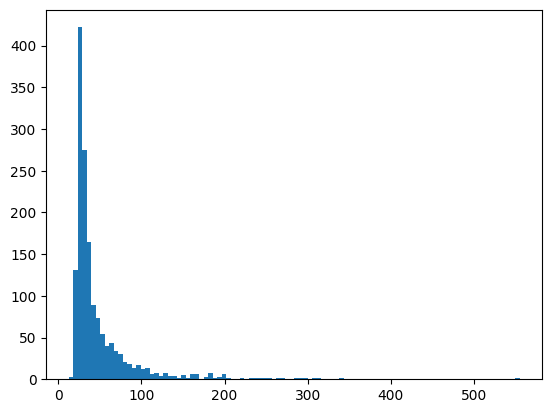

In [ ]:
kde = gaussian_kde(means)
x_kde = np.linspace(min(means), max(means), 100)
kde_values = kde(x_kde)


fig, ax = plt.subplots()
# ax.plot(x_kde, kde_values)
ax.hist(means, bins=100)
# ax.hist(means, bins=100, alpha=0.3)
# ax.set_xscale('log')
# ax.set_yscale('log')

## sanity check... aggregating across stream orders looks like a pareto!!!!!!

In [ ]:
ordermeds = widths_filtered.groupby(['iindex', 'NewSO'])['sat_width_m'].agg('median')

,,sat_width_m
iindex,NewSO,
692,11,92.335726
932,12,235.343519
1082,7,31.575887
1877,7,41.712206
3018,8,31.602672
...,...,...
254274,10,84.373380
255389,12,273.521623
255765,10,204.985763
